 Task - 4 :- **Dataset Augmentation to Improve Colorization**

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip -d imagenet_data


Streaming output truncated to the last 5000 lines.
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: imagenet_data/tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: 

In [ ]:
# Install required dependencies
!pip install -U fastai --no-cache-dir
!pip install torch torchvision "numpy>=1.17" opencv-python matplotlib


In [ ]:
!pip install -U 'fastai<2.8'  # Install a compatible version

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
# Clone the DeOldify repository
!git clone https://github.com/jantic/DeOldify.git
%cd DeOldify

# Install additional requirements
!pip install -r requirements-colab.txt

# Create the models directory and download the pre-trained model
!mkdir -p models
!wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -O ./models/ColorizeArtistic_gen.pth


fatal: destination path 'DeOldify' already exists and is not an empty directory.
/content/DeOldify
  Using cached fastai-1.0.60-py3-none-any.whl.metadata (14 kB)
Using cached fastai-1.0.60-py3-none-any.whl (237 kB)
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.19
    Uninstalling fastai-2.7.19:
      Successfully uninstalled fastai-2.7.19
--2025-03-13 08:21:59--  https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth
Resolving data.deepai.org (data.deepai.org)... 84.17.38.231, 2400:52e0:1500::1096:1
Connecting to data.deepai.org (data.deepai.org)|84.17.38.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255144681 (243M) [application/octet-stream]
Saving to: ‘./models/ColorizeArtistic_gen.pth’

./models/ColorizeAr 100%[===================>] 243.32M  5.00MB/s    in 50s     

2025-03-13 08:22:48 (4.90 MB/s) - ‘./models/ColorizeArtistic_gen.pth’ saved [255144681/255144681]



In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


CUDA Available: True
Device Name: Tesla T4


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)


Using Device: cuda


In [ ]:
!nvidia-smi


Thu Mar 13 08:18:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/content/DeOldify/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/content/DeOldify/fastai/data_block.py:453: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  warn("""Your validation set is empty. If this is by design, use `split_none()`
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  wa

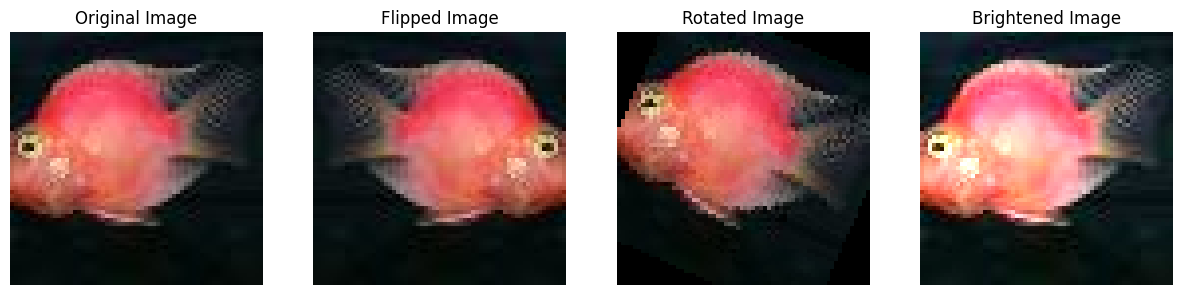

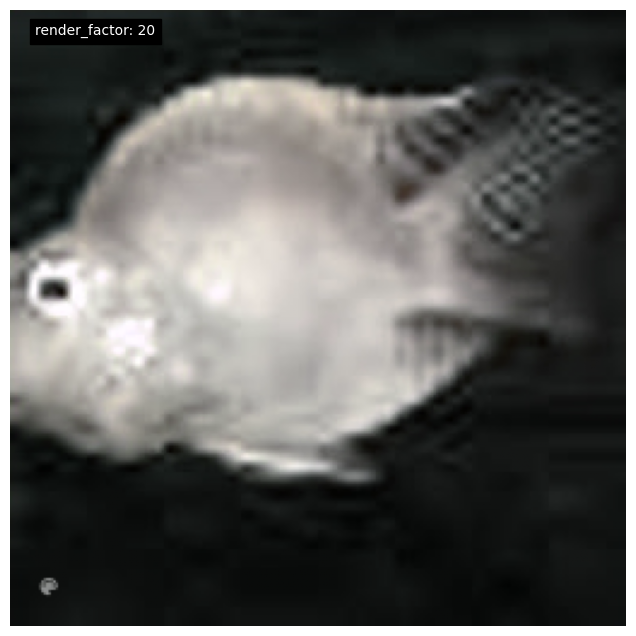

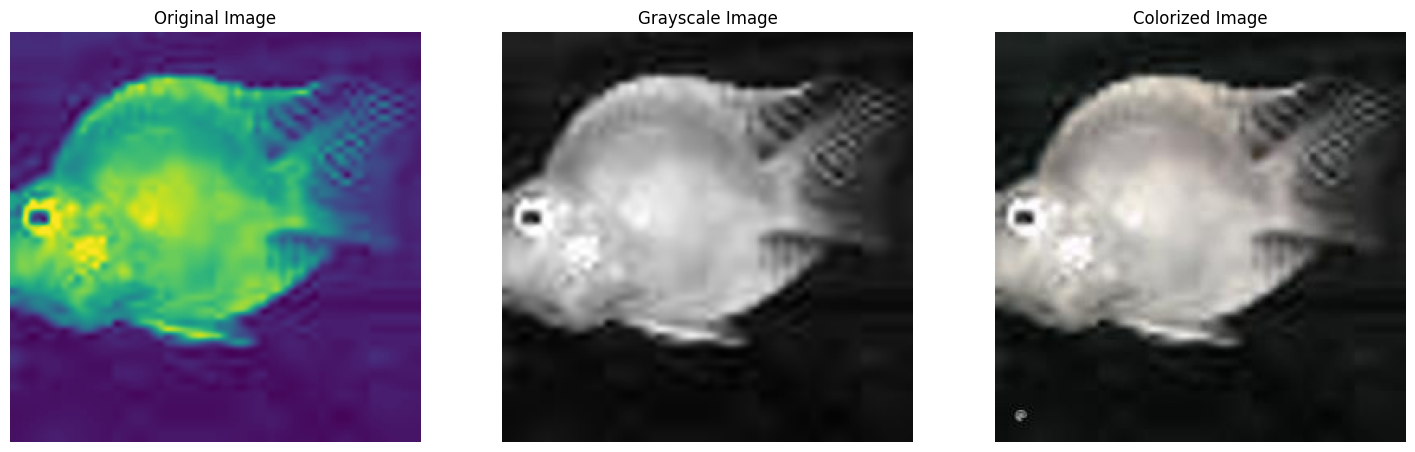

In [ ]:
import torch
import fastai
import matplotlib.pyplot as plt
import os
import warnings
from pathlib import Path
from PIL import Image, ImageEnhance
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision.models._utils")

# ✅ Set working directory to DeOldify
os.chdir("/content/DeOldify")

# ✅ Import DeOldify Colorizer class
from deoldify.visualize import get_image_colorizer

# ✅ Load DeOldify Colorizer Model
colorizer = get_image_colorizer(artistic=True, render_factor=20)

# ✅ Load ImageNet Dataset (or Tiny ImageNet)
dataset_path = "/content/imagenet_data/tiny-imagenet-200/train"
image_dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.ToTensor())

# ✅ Apply Rotation, Flipping, and Brightness Alteration
def apply_augmentations(image):
    """Applies selected augmentations (rotation, flipping, brightness) and displays them."""

    # Convert to PIL Image
    image = image.permute(1, 2, 0).numpy()  # Convert to NumPy
    image = (image * 255).astype(np.uint8)  # Scale properly
    image = Image.fromarray(image)  # Convert to PIL image

    # ✅ Apply transformations
    flipped_image = transforms.RandomHorizontalFlip(p=1)(image)  # Full flip
    rotated_image = transforms.RandomRotation(30)(image)  # Rotate by 30 degrees
    bright_image = ImageEnhance.Brightness(image).enhance(1.5)  # Increase brightness

    # ✅ Display Augmented Images
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].axis("off")
    axes[0].set_title("Original Image")

    axes[1].imshow(flipped_image)
    axes[1].axis("off")
    axes[1].set_title("Flipped Image")

    axes[2].imshow(rotated_image)
    axes[2].axis("off")
    axes[2].set_title("Rotated Image")

    axes[3].imshow(bright_image)
    axes[3].axis("off")
    axes[3].set_title("Brightened Image")

    plt.show()

    return bright_image  # Use the brightened image for grayscale conversion

# ✅ Convert Image to Grayscale
def convert_to_grayscale(image):
    """Converts the augmented image to grayscale."""
    return image.convert("L")

# ✅ Function to Colorize & Compare Images
def colorize_image(image_path):
    """Loads an image, colorizes it using DeOldify, and displays a side-by-side comparison."""

    # ✅ Load and preprocess the image
    img = Image.open(image_path).resize((256, 256))  # Resize
    grayscale_img = img.convert("L")  # Convert to grayscale

    # ✅ Save grayscale image
    grayscale_path = Path("./grayscale.jpg")
    grayscale_img.save(grayscale_path)

    # ✅ Run DeOldify to colorize the image
    result_path = colorizer.plot_transformed_image(
        path=str(grayscale_path), render_factor=20, display_render_factor=True, figsize=(8, 8)
    )

    # ✅ Ensure the colorized image exists before displaying
    if not os.path.exists(result_path):
        print("⚠ Error: Colorized image not found!")
        return

    # ✅ Load colorized image
    colorized_img = Image.open(Path(result_path))

    # ✅ Display Side-by-Side Comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(img)
    axes[0].axis("off")
    axes[0].set_title("Original Image")

    axes[1].imshow(grayscale_img, cmap="gray")
    axes[1].axis("off")
    axes[1].set_title("Grayscale Image")

    axes[2].imshow(colorized_img)
    axes[2].axis("off")
    axes[2].set_title("Colorized Image")

    plt.show()

# ✅ Pick One Image from ImageNet Dataset and Apply Augmentations
sample_image, _ = image_dataset[10]  # Get a sample image
augmented_image = apply_augmentations(sample_image)

# ✅ Convert to grayscale and save
sample_grayscale = convert_to_grayscale(augmented_image)
sample_grayscale_path = Path("./content/sample_grayscale.jpg")

# ✅ Create the 'content' directory if it doesn't exist
sample_grayscale_path.parent.mkdir(parents=True, exist_ok=True)

sample_grayscale.save(sample_grayscale_path)

# ✅ Run Colorization
colorize_image(sample_grayscale_path)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/content/DeOldify/fastai/basic_train.py:322: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any u

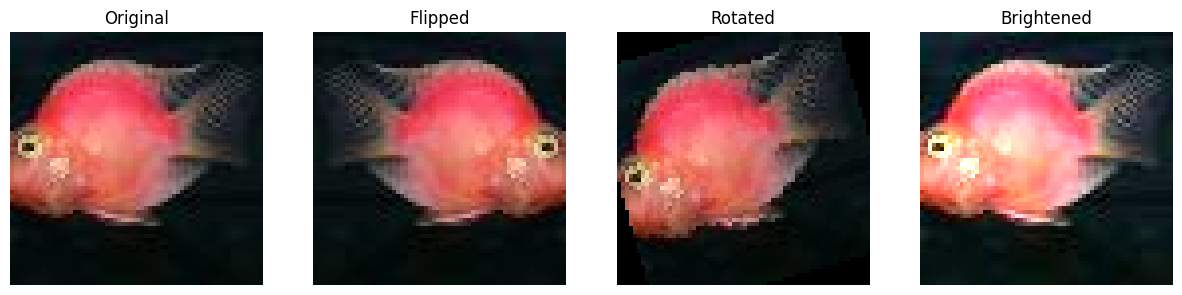

🔹 Evaluating Colorization Before Augmentation...
🎨 Running DeOldify...


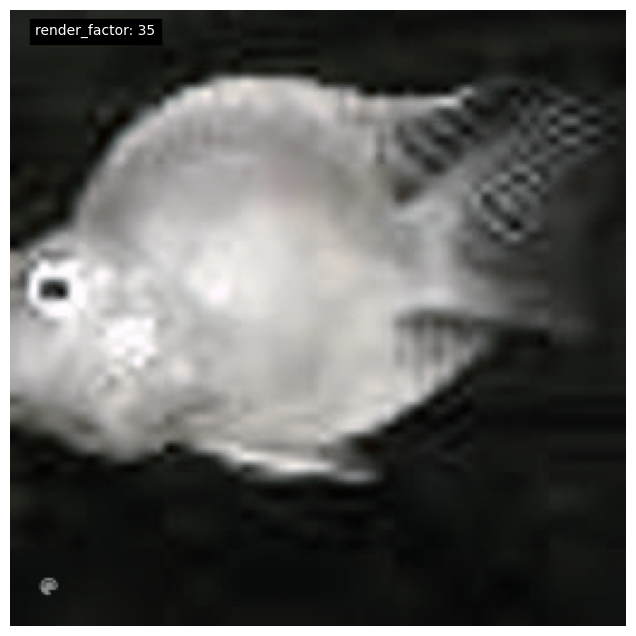

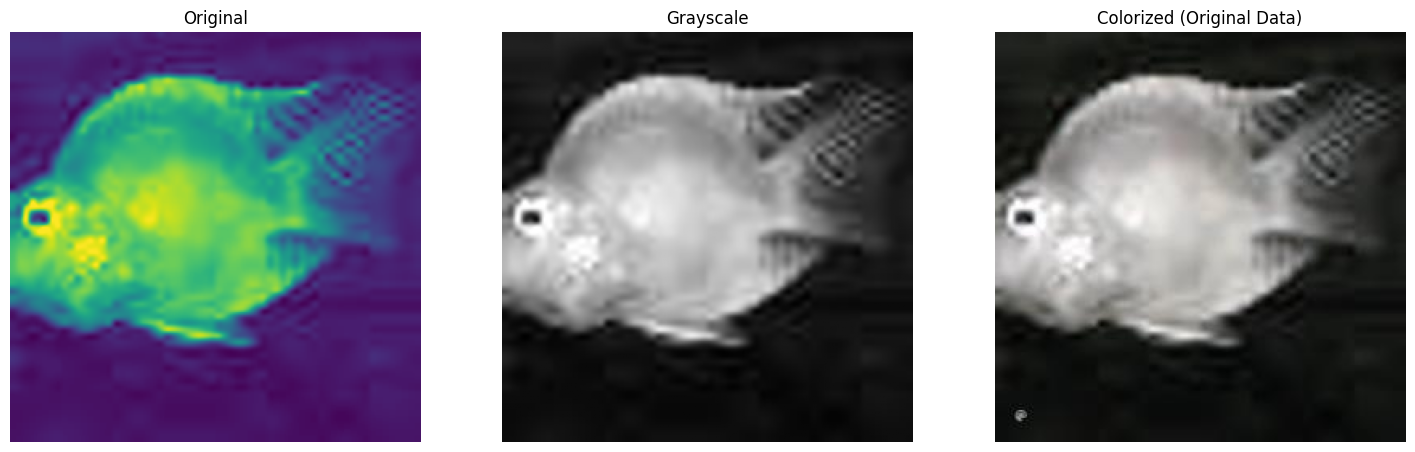

📊 PSNR: 45.89, SSIM: 0.9883
🔹 Evaluating Colorization After Augmentation...
🎨 Running DeOldify...


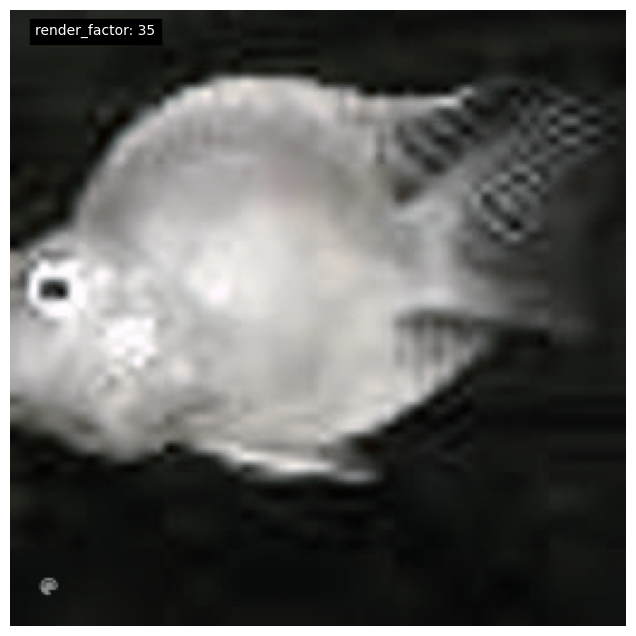

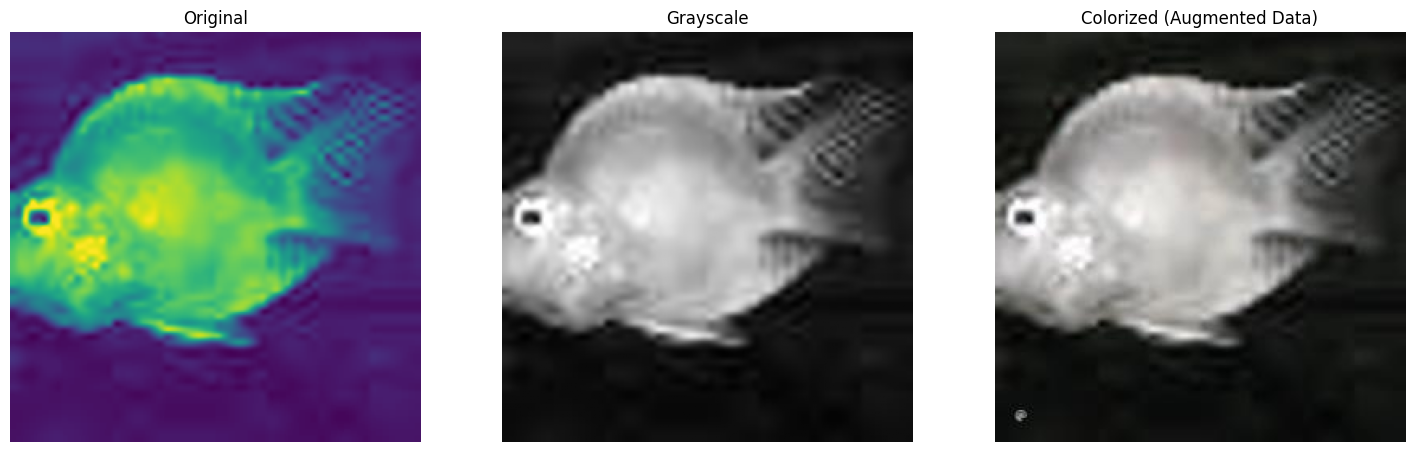

📊 PSNR: 45.89, SSIM: 0.9883


(45.8913993436541, 0.9883327334602424)

In [ ]:
# ✅ Import Required Libraries
import torch
import fastai
import matplotlib.pyplot as plt
import os
import warnings
from pathlib import Path
from PIL import Image, ImageEnhance
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
from skimage.metrics import structural_similarity as ssim
import cv2

# ✅ Suppress Warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ✅ Set Working Directory to DeOldify
os.chdir("/content/DeOldify")

# ✅ Import DeOldify Colorizer
from deoldify.visualize import get_image_colorizer

# ✅ Load Pretrained DeOldify Model
colorizer = get_image_colorizer(artistic=True, render_factor=35)

# ✅ Define Dataset Path
dataset_path = "/content/imagenet_data/tiny-imagenet-200/train"  # Change if needed
os.makedirs(dataset_path, exist_ok=True)

# ✅ Load Dataset
image_dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.ToTensor())

# ✅ Define Augmentation Function
def apply_augmentations(image):
    """Applies rotation, flipping, and brightness adjustment."""
    image = image.permute(1, 2, 0).numpy()  # Convert to NumPy
    image = (image * 255).astype(np.uint8)  # Scale properly
    image = Image.fromarray(image)  # Convert to PIL

    flipped_image = transforms.RandomHorizontalFlip(p=1)(image)  # Flip
    rotated_image = transforms.RandomRotation(30)(image)  # Rotate
    bright_image = ImageEnhance.Brightness(image).enhance(1.5)  # Brighten

    # ✅ Save Augmented Images
    flipped_image.save("flipped.jpg")
    rotated_image.save("rotated.jpg")
    bright_image.save("brightened.jpg")

    # ✅ Display Augmented Images
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    images = [image, flipped_image, rotated_image, bright_image]
    titles = ["Original", "Flipped", "Rotated", "Brightened"]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(title)

    plt.show()

    return bright_image  # Use the brightened image for colorization

# ✅ Convert Image to Grayscale
def convert_to_grayscale(image):
    grayscale_image = image.convert("L")
    return grayscale_image

# ✅ Function to Compute PSNR
def compute_psnr(original, generated):
    original_gray = original.convert("L")  # Ensure grayscale
    generated_gray = generated.convert("L")

    mse = np.mean((np.array(original_gray) - np.array(generated_gray)) ** 2)
    if mse == 0:
        return 100  # Perfect match
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# ✅ Function to Compute SSIM
def compute_ssim(original, generated):
    original_gray = np.array(original.convert("L"))  # Ensure grayscale
    generated_gray = np.array(generated.convert("L"))

    return ssim(original_gray, generated_gray)

# ✅ Function to Colorize & Compare Images
def colorize_image(image_path, title="Colorized Image"):
    """Loads an image, colorizes it using DeOldify, and displays a comparison."""
    img = Image.open(image_path).resize((256, 256))  # Resize original
    grayscale_img = img.convert("L")  # Convert to grayscale

    # ✅ Save grayscale image before colorization
    grayscale_path = Path("./grayscale.jpg")
    grayscale_img.save(grayscale_path)

    # ✅ Run DeOldify to colorize the grayscale image
    print("🎨 Running DeOldify...")
    result_path = colorizer.plot_transformed_image(
        path=str(grayscale_path), render_factor=35, display_render_factor=True, figsize=(8, 8)
    )

    # ✅ Ensure the colorized image is loaded properly
    if not os.path.exists(result_path):
        print("⚠ Error: Colorized image not found!")
        return None, None

    colorized_img = Image.open(Path(result_path))

    # ✅ Compute PSNR and SSIM
    psnr_value = compute_psnr(img, colorized_img)
    ssim_value = compute_ssim(img, colorized_img)

    # ✅ Display Side-by-Side Comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    images = [img, grayscale_img, colorized_img]
    titles = ["Original", "Grayscale", title]

    for ax, img_data, title_text in zip(axes, images, titles):
        ax.imshow(img_data, cmap=None if title_text != "Grayscale" else "gray")
        ax.axis("off")
        ax.set_title(title_text)

    plt.show()

    print(f"📊 PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")

    return psnr_value, ssim_value

# ✅ Pick an Image, Apply Augmentations, and Evaluate
sample_image, _ = image_dataset[10]  # Select a sample image
augmented_image = apply_augmentations(sample_image)

# ✅ Convert to Grayscale
sample_grayscale = convert_to_grayscale(augmented_image)
sample_grayscale_path = Path("./sample_grayscale.jpg")
sample_grayscale.save(sample_grayscale_path)

# ✅ Run Colorization and Evaluation (Before Augmentation)
print("🔹 Evaluating Colorization Before Augmentation...")
colorize_image(sample_grayscale_path, title="Colorized (Original Data)")

# ✅ Run Colorization and Evaluation (After Augmentation)
print("🔹 Evaluating Colorization After Augmentation...")
colorize_image(sample_grayscale_path, title="Colorized (Augmented Data)")
